In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *

import meteo                    # wind_dir_speed
import metpy.calc as mpcalc
from metpy.units import units
import lcl

from windrose import WindroseAxes
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background

from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d, perc_distribution_pvalue
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
# if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
#     sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')    
    
tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')

In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

In [6]:
QVAPOR = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')])
QVAPOR = QVAPOR['QVAPOR'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
QVAPOR_day = QVAPOR.groupby('time_counter.day').mean().values

In [7]:
# load W component - in m/s
W_day = xr.open_dataset(wrf_files[files_ls.index('W.nc')])
W_day = W_day['W'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000')).groupby('time_counter.day').mean()
W_day = W_day.where(sea_mask_modified, drop=False)


W_inter = np.zeros_like(QVAPOR_day)
for i in range(39):
    W_inter[:,i,:,:] = (W_day[:,i+1,:,:]+W_day[:,i,:,:])*0.5

In [8]:
lon = W_day['nav_lon_grid_M'].values
lat = W_day['nav_lat_grid_M'].values

In [9]:
# compute anomalies daily data
s = 100

dw_inter = np.zeros_like(W_inter)

for t in range(0,W_inter.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,dw_inter.shape[1]):
        w_ave = gm.nan_gaussian_filter(W_inter[t,h],s)  
        dw_inter[t,h] = W_inter[t,h] - w_ave

0
10
20


In [10]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask_modified, drop=False).values; 

T2_day = ds_hourly['T2']  #.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
T2_day = T2_day.groupby('time_counter.day').mean()
T2_day = T2_day.where(sea_mask_modified, drop=False).values

buoya = sst_day - T2_day

In [32]:
s = 30

dsst_day = np.zeros_like(sst_day)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    w_ave = gm.nan_gaussian_filter(sst_day[t],s)  
    dsst_day[t] = sst_day[t] - w_ave

0
10
20


In [33]:
# compute anomalies daily data
s = 30

dq_day = np.zeros_like(QVAPOR_day)

for t in range(0,QVAPOR_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,QVAPOR_day.shape[1]):
        w_ave = gm.nan_gaussian_filter(QVAPOR_day[t,h],s)  
        dq_day[t,h] = QVAPOR_day[t,h] - w_ave

0
10
20


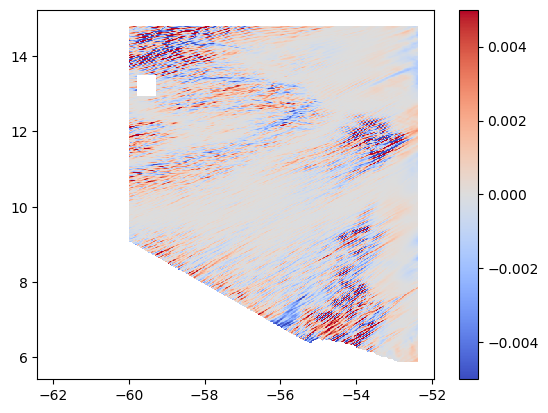

In [30]:
plt.pcolormesh(lon, lat, (dw_inter*dq_day)[10,5]*1e3, cmap='coolwarm', vmin=-0.5e-2, vmax=0.5e-2)
plt.colorbar()

## integrate w'q' up to 10th level (approx BL height)

In [33]:
wq_bulk = (dw_inter*dq_day)[:,0:10]
wq_bulk = np.nansum(wq_bulk, axis=1)

In [34]:
wq_bulk.shape

(29, 546, 573)

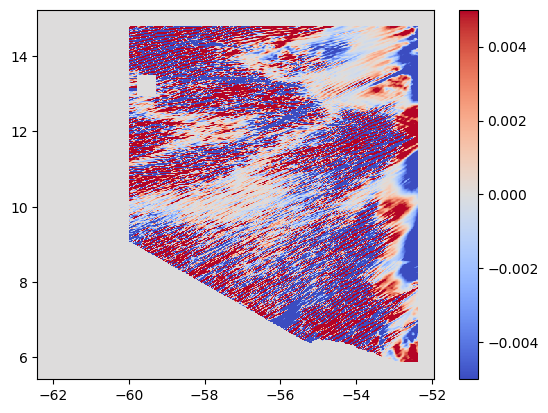

In [37]:
plt.pcolormesh(lon, lat, wq_bulk[10]*1e3, cmap='coolwarm', vmin=-0.5e-2, vmax=0.5e-2)
plt.colorbar()

## compute covariances 

In [13]:
def local_variance(field,sigma):
    bar = gm.nan_gaussian_filter(field**2,sigma)
    return bar

def local_covariance(field_a,field_b,sigma):
    bar = gm.nan_gaussian_filter(field_a*field_b,sigma)
    return bar

In [34]:
s = 30

cov_wq = np.zeros_like(dw_inter)

for t in range(dw_inter.shape[0]):
    if t%10 == 0:
        print(t)
    for h in range(dw_inter.shape[1]):
        cov_wq[t,h] = local_covariance(dw_inter[t,h], dq_day[t,h], s)

cov_wq_bulk = cov_wq[:,0:10]; cov_wq_bulk = np.nansum(cov_wq_bulk, axis=1)

0
10
20


In [22]:
cov_wq.shape

(29, 39, 546, 573)

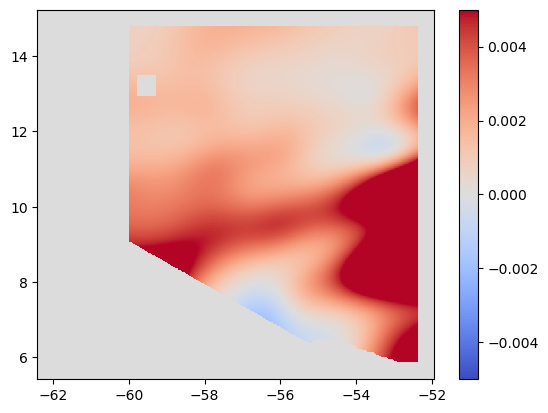

In [38]:
plt.pcolormesh(lon, lat, cov_wq_bulk[5]*1e3, cmap='coolwarm', vmin=-0.5e-2, vmax=0.5e-2)
plt.colorbar()

In [31]:
sst = ds_hourly['SST']          
sst = sst.where(sea_mask_modified, drop=False).values[::3]; 

T2 = ds_hourly['T2']  #.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
T2 = T2.where(sea_mask_modified, drop=False).values[::3]

Tdiff_3h = sst - T2

In [13]:
#### percentile distributionnssss

## W DISTRIBUTION
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_w, pstd_w, pstderr_w, pnpoints_w, ppvalue_w_sub = \
dist_3d_subsample(dsst_day.values, W_day.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

# pdist_dsst, pdist_w, pstd_w, pstderr_w, pnpoints_w, ppvalue_w_sub = \
# dist_3d_subsample(dsst_3h.values*tourbillons_mask, W.values*tourbillons_mask, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [41]:
#### percentile distributionnssss

## W  anoms  DISTRIBUTION
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dw, pstd_dw, pstderr_dw, pnpoints_dw, ppvalue_dw_sub = \
dist_3d_subsample(dsst_day.values*tourbillons_mask, dw_day*tourbillons_mask, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [14]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()
PBLH_day = PBLH_day.where(sea_mask_modified, drop=False).values;

# PBLH IN PRESSURE VALUES! 
# output is in hPa
PBLH_pres = mpcalc.height_to_pressure_std(PBLH_day*units.meters)
PBLH_pres = PBLH_pres.magnitude #.m_as('hPa')

In [15]:
# DISTRIBUTION PBLH vs dSST bin - DAILY 
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

#  PBLH distrib

# perc
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstderr_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day.values, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')


pdist_sst, pdist_PBLH_sst, pstd_PBLH_sst, pstderr_PBLH_sst, pnpoints_PBLH_sst, ppvalue_PBLH_sst = \
distrib_2d(sst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')


In [16]:
mean_vert_pres = np.load('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy')

Text(0.4, 925, 'PBLH')

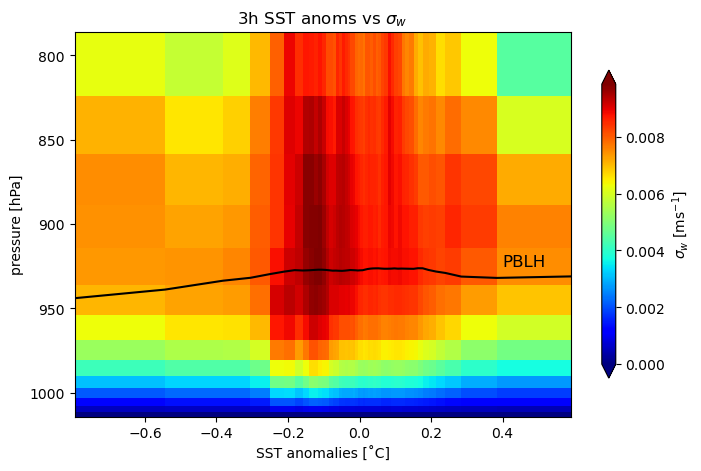

In [17]:
# figure W and dW vs dSST bin - DAILY
p_level_plot = int(15)

anoms = False

x = pdist_dsst 
var = pstd_w[0:p_level_plot,:]   #  pdist_dw[0:p_level_plot,:] if anoms else pdist_w[0:p_level_plot,:] 
# minval = -0.001
# maxval = -minval
# title = 'Percentiles - daily dSST vs vertical velocity anomalies' if anoms else \
#         "Percentiles - daily SST' vs vertical velocity"


title_sigma = "3h SST anoms vs $\sigma_{w}$"

fig, ax1 = plt.subplots(figsize=(8, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, cmap='jet')  # vmin=minval, vmax=maxval,
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title_sigma} ')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label(r"$\sigma_{w}$ [$\rm ms^{-1}$]")  #$\sigma_{w}$


x_pbl = pdist_dsst 
var_pbl = pdist_PBLH_dsst #if perc else dist_PBLH_dsst
ax1.plot(x_pbl, var_pbl, 'k')
ax1.text(0.4, 925, 'PBLH', fontsize=12)



# DEF punti significativi (pvalue < 0.05)
# pval = ppvalue_dw_sub[0:p_level_plot] if anoms else ppvalue_w_sub[0:p_level_plot] 
# GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
# signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
# dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
# for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
#     cond1 = pval[h,:-1] > 0.05
#     cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
#     cond = (cond1) | (cond2)
# #     cond = cond1
#     signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
#     signif_Lcorr_H[h, cond] = GPbin[h]
#     dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
# plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')


# path_img = '/venus/tesi_ale/img_EU/WIND/daily/FEB/' 
# filename = path_img + 'pdist_dsst_dW_day_lowtropo.png' if anoms else path_img + 'pdist_dsst_W_day_lowtropo.png' 
# # plt.savefig(filename)
# print(filename)                #'pdist_dsst_SigmaW_day_lowtropo.png' #
# del filename

## sigma_w against SST-T2

(694, 546, 573)

In [18]:
## W DISTRIBUTION
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_buoya, pdist_w_bu, pstd_w_bu, pstderr_w_bu, pnpoints_w_bu, ppvalue_w_bu_sub = \
dist_3d_subsample(buoya, W_day.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [19]:
### PBLH - buoya
pdist_buoya, pdist_PBLH_bu, pstd_PBLH_bu, pstderr_PBLH_bu, pnpoints_PBLH_bu, ppvalue_PBLH_bu = \
distrib_2d(buoya, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')

Text(-0.1, 925, 'PBLH')

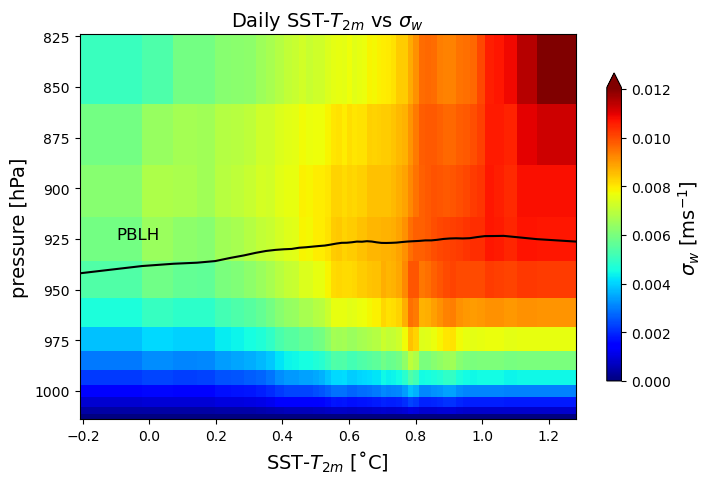

In [22]:

p_level_plot = int(14)

anoms = True

x = pdist_buoya
var = pstd_w_bu[0:p_level_plot,:] #if anoms else pdist_w[0:p_level_plot,:] 
# minval = 0 #-0.001
# maxval = 0.01 #-minval
title = "Daily SST-$T_{2m}$ vs $\sigma_{w}$" #if anoms else \ "Percentiles - daily SST' vs vertical velocity"

fig, ax1 = plt.subplots(figsize=(8, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, cmap='jet') #vmin=minval, vmax=maxval,
ax1.set_xlabel('SST-$T_{2m}$ [˚C]', fontsize=14); ax1.set_ylabel('pressure [hPa]', fontsize=14)
plt.title(f'{title} ', fontsize=14)
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='max')  
cbar.set_label(r"$\sigma_{w}$ [$\rm ms^{-1}$]", fontsize=14) 


x_pbl = pdist_buoya 
var_pbl = pdist_PBLH_bu # pdist_PBLH_dsst
ax1.plot(x_pbl, var_pbl, 'k')
ax1.text(-0.1, 925, 'PBLH', fontsize=12)



# DEF punti significativi (pvalue < 0.05)
# pval = ppvalue_dw_sub[0:p_level_plot] if anoms else ppvalue_w_sub[0:p_level_plot] 
# GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
# signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
# dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
# for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
#     cond1 = pval[h,:-1] > 0.05
#     cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
#     cond = (cond1) | (cond2)
# #     cond = cond1
#     signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
#     signif_Lcorr_H[h, cond] = GPbin[h]
#     dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
# plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')


# path_img = '/venus/tesi_ale/img_EU/WIND/daily/FEB/' 
# filename = path_img + 'pdist_dsst_dW_day_lowtropo.png' if anoms else path_img + 'pdist_dsst_W_day_lowtropo.png' 
# # plt.savefig(filename)
# print(filename)                #'pdist_dsst_SigmaW_day_lowtropo.png' #
# del filename

IN DAILY MEANS, ONLY THE GENERAL SUBSIDENCE IS VISIBLE

In [13]:
lat_reduced = lat_M[:,0]
exist_ = np.argwhere(lat_reduced==10.01075)
print(exist_)

[[253]]


In [45]:
# visualize what is going on along (-56, 7:14) and (-60:-53, 10)

vert_line = np.argwhere((lon_M==-55.983223) & (lat_M >=7) & (lat_M <=14))
hor_line = np.argwhere((lat_M==10.01075) & (lon_M >=-60) & (lon_M <=-53))

In [25]:
# visualize what is going on along (-56, 7:14) and (-60:-53, 10)

vert_line = np.argwhere((lon_M==-55.983223) & (lat_M >=7) & (lat_M <=14))
hor_line = np.argwhere((lat_M==10.01075) & (lon_M >=-60) & (lon_M <=-53))

lon_verticalline = int(np.unique(vert_line[:,1]))
w_vertline = W_inter[:,:,np.unique(vert_line[:,0]), lon_verticalline]

lat_horizontalline = int(np.unique(hor_line[:,0]))
w_horline = W_inter[:,:,lat_horizontalline, np.unique(hor_line[:,1])]



v_vertline = V[:,:,vert_line[:,0], vert_line[:,1]]; GPH_vert = GPH_inter[:,:,vert_line[:,0], vert_line[:,1]]
u_horline = U[:,:,hor_line[:,0], hor_line[:,1]];    GPH_hor  = GPH_inter[:,:,hor_line[:,0], hor_line[:,1]]

In [18]:
v_vertline = V[:,:,vert_line[:,0], vert_line[:,1]]; GPH_vert = GPH_inter[:,:,vert_line[:,0], vert_line[:,1]]
u_horline = U[:,:,hor_line[:,0], hor_line[:,1]];    GPH_hor  = GPH_inter[:,:,hor_line[:,0], hor_line[:,1]]

In [26]:
dwdy_vert = mpcalc.first_derivative(w_vertline*units('m/s'), axis=2,x=None, delta=2000.*units.meters) #, x=GPH_vert*units.meters)
dwdx_hor = mpcalc.first_derivative(w_horline*units('m/s'), axis=2, x=None, delta=2000.*units.meters) #, x=GPH_hor*units.meters)


In [20]:
dvdz_vert = mpcalc.first_derivative(v_vertline*units('m/s'), axis=1, x=GPH_vert*units.meters)
dudz_hor = mpcalc.first_derivative(u_horline*units('m/s'), axis=1, x=GPH_hor*units.meters)

In [27]:
vort_horline = dudz_hor - dwdx_hor
vort_vertline = dwdy_vert - dvdz_vert

In [58]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

LH = ds_hourly['LH'].groupby('time_counter.day').mean()            
LH = LH.where(sea_mask, drop=False).values;
LH_vertline = LH[:, vert_line[:,0],lon_verticalline]
LH_horline = LH[:, lat_horizontalline,hor_line[:,1]]


In [60]:
with open('/venus/tesi_ale/data_EU/LH/daily/FEB/dLH_day_feb.npy', 'rb') as f:
    dLH = np.load(f)
    f.close()

dLH_vertline = dLH[:, vert_line[:,0],lon_verticalline]
dLH_horline = dLH[:, lat_horizontalline,hor_line[:,1]]

In [76]:
PBLH = ds_hourly['PBLH'].groupby('time_counter.day').mean()
PBLH_vertline = PBLH[:, vert_line[:,0],lon_verticalline];  PBLH_vertline = mpcalc.height_to_pressure_std(PBLH_vertline*units.meters)
PBLH_horline = PBLH[:, lat_horizontalline,hor_line[:,1]];  PBLH_horline = mpcalc.height_to_pressure_std(PBLH_horline*units.meters)

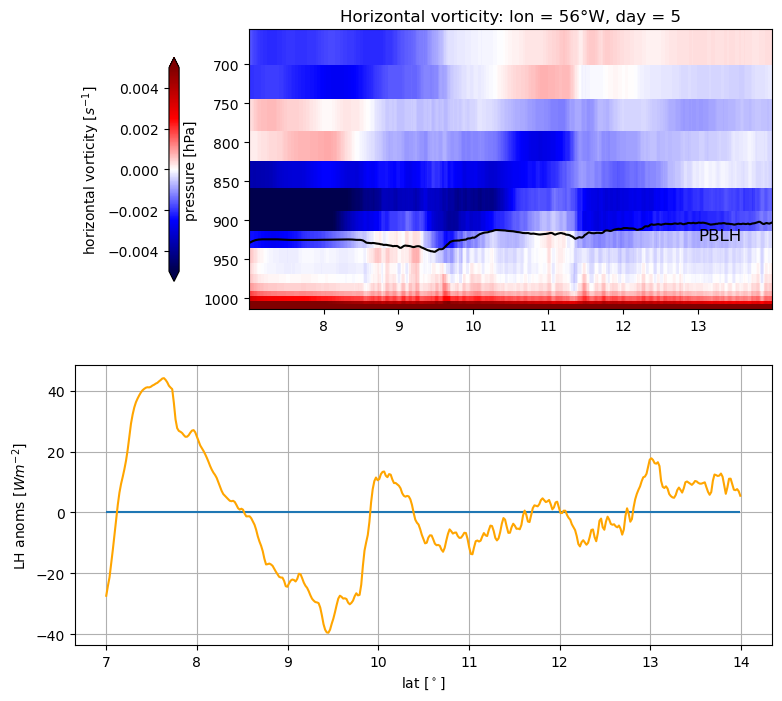

In [80]:
lev = int(18); day = int(5)

vertical = True
x = lat_M[vert_line[:,0],lon_verticalline] if vertical else lon_M[lat_horizontalline,hor_line[:,1]]
var = vort_vertline[day, 0:lev, :].magnitude if vertical else vort_horline[day, 0:lev, :].magnitude
xlab = r'lat [$^\circ$]' if vertical else r'lon [$^\circ$]'
title = f'Horizontal vorticity: lon = 56°W, day = {day}' if vertical else f'Horizontal vorticity at lat = 10°N, day = {day}'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8))  
ax1.invert_yaxis()


# plot for vorticity and PBLH

p1 = ax1.pcolormesh(x, mean_vert_pres[0:lev], var, \
               vmin=-0.005, vmax=0.005, cmap='seismic')


ax1.set_ylabel('pressure [hPa]')
ax1.set_title(title)
cbar = plt.colorbar(p1,ax=ax1, location='left', shrink=0.8, extend='both') 
cbar.set_label('horizontal vorticity [$s^{-1}$]')

#twin = ax1.twinx()
var_PBL = PBLH_vertline if vertical else PBLH_horline
ax1.plot(x, var_PBL[day,:], 'k'); ax1.text(13, 925, 'PBLH', fontsize=12)


### plot to have LH / dLH at hand

var_LH = LH_vertline if vertical else LH_horline
var_dLH = dLH_vertline if vertical else dLH_horline

ax2.plot(x, var_dLH[day,:], 'orange')
ax2.set_ylabel('LH anoms [$Wm^{-2}$]'); ax2.set_xlabel(xlab);
ax2.grid(); ax2.hlines(0, xmin=x[0], xmax=x[-1])

# on subdaily timescale?

In [11]:
# load W component - in m/s
U = xr.open_dataset(wrf_files[files_ls.index('U.nc')])
U = U['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-07T22:30:00.000000000'))


V = xr.open_dataset(wrf_files[files_ls.index('V.nc')])
V = V['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-07T22:30:00.000000000'))



In [13]:
U = (U[:,:,:,:-1]+U[:,:,:,1:])*0.5
V = (V[:,:,:-1,:]+V[:,:,1:,:])*0.5

U = U.where(sea_mask, drop=False)
V = V.where(sea_mask, drop=False)

In [15]:
# load W component - in m/s
W = xr.open_dataset(wrf_files[files_ls.index('W.nc')])
W = W['W'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-07T22:30:00.000000000'))
W = W.where(sea_mask, drop=False)


lon_M = W['nav_lon_grid_M'].values
lat_M = W['nav_lat_grid_M'].values

W_inter = np.zeros_like(U)
for i in range(39):
    W_inter[:,i,:,:] = (W[:,i+1,:,:]+W[:,i,:,:])*0.5

In [16]:
# reading geopotential height
GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')])
GPH_base = GPH_base['PHB']/9.81

GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')])
GPH = GPH.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-07T22:30:00.000000000'))
GPH = GPH['PH']/9.81

GPH = GPH_base + GPH
GPH = GPH.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')
GPH = GPH.where(sea_mask, drop=False)

# GPH = GPH.groupby('time_counter.day').mean()

#GPH_base = GPH_base.where(sea_mask, drop=False)
del GPH_base

In [18]:
# vertical interpolation of geopotential
GPH_inter = np.zeros_like(U)
for i in range(39):
    GPH_inter[:,i,:,:] = (GPH[:,i+1,:,:]+GPH[:,i,:,:])*0.5

In [ ]:
'''vert_line = np.argwhere((lon_M==-55.983223) & (lat_M >=7) & (lat_M <=14))
hor_line = np.argwhere((lat_M==10.01075) & (lon_M >=-60) & (lon_M <=-53))'''

In [ ]:
'''# visualize what is going on along (-56, 7:14) and (-60:-53, 10)
lon_verticalline = int(np.unique(vert_line[:,1]))
w_vertline = W_inter[:,:,np.unique(vert_line[:,0]), lon_verticalline]

lat_horizontalline = int(np.unique(hor_line[:,0]))
w_horline = W_inter[:,:,lat_horizontalline, np.unique(hor_line[:,1])]
'''

In [ ]:
'''v_vertline = V[:,:,vert_line[:,0], vert_line[:,1]]; GPH_vert = GPH_inter[:,:,vert_line[:,0], vert_line[:,1]]
u_horline = U[:,:,hor_line[:,0], hor_line[:,1]];    GPH_hor  = GPH_inter[:,:,hor_line[:,0], hor_line[:,1]]'''

In [ ]:
dwdy = mpcalc.first_derivative(W*units('m/s'), axis=2,x=None, delta=2000.*units.meters) #, x=GPH_vert*units.meters)
dwdx = mpcalc.first_derivative(W*units('m/s'), axis=2, x=None, delta=2000.*units.meters) #, x=GPH_hor*units.meters)

dvdz = mpcalc.first_derivative(V*units('m/s'), axis=1, x=GPH_inter*units.meters)
dudz = mpcalc.first_derivative(U*units('m/s'), axis=1, x=GPH_inter*units.meters)

In [ ]:
eta = dwdy-dvdz
csi = dudz-dwdx 

LINK WITH LHF ANOMALIES?

In [20]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-07T22:30:00.000000000'))

LH = ds_hourly['LH']   #.groupby('time_counter.day').mean()            
LH = LH.where(sea_mask, drop=False).values;
# LH_vertline = LH[:, vert_line[:,0],lon_verticalline]
# LH_horline = LH[:, lat_horizontalline,hor_line[:,1]]


In [22]:
LH = LH[::3,:,:]

In [23]:
s = 75   # CAREFUL!!

dLH = np.zeros(LH.shape)

for t in range(0,LH.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    LH_ave = gm.nan_gaussian_filter(LH[t],s)                             
    dLH[t] = LH[t] - LH_ave

0
10
20
30
40
50


In [ ]:
#### PBLH
PBLH = ds_hourly['PBLH']              
PBLH = PBLH.where(sea_mask, drop=False)
PBLH = PBLH[::3,:,:]


In [ ]:
pdist_dLH, pdist_PBLH_dLH, pstd_PBLH_dLH, pstd_err_PBLH_dLH, pnpoints_PBLH_dLH, ppvalue_PBLH_dLH = \
distrib_2d(dLH, PBLH, perc_step, nbins, popmean, perc_fixbin='perc')

In [ ]:
### PBLH conversion to hPa
pdist_PBLH_dLH = mpcalc.height_to_pressure_std(pdist_PBLH_dLH*units.meters)

In [ ]:
pdist_dLH, pdist_eta, pstd_eta, pstderr_eta, pnpoints_eta, ppvalue_eta_sub = \
dist_3d_subsample(dLH, eta.magnitude, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

In [ ]:
mean_vert_pres = np.load('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy')

In [ ]:
# figure dBV or BV vs dSST bin - DAILY
p_level_plot = int(15)


x = pdist_dLH #if perc else dist_dsst_day
var = pdist_eta[0:p_level_plot,:]
# minval = -10. #if perc else -0.05
# maxval = -minval
title = 'Eta (along x) distributions'

fig, ax1 = plt.subplots(figsize=(10, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, cmap='seismic')  # vmin=minval, vmax=maxval, )
ax1.set_xlabel('LH anomalies [W/m2]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} - 3hr dLH vs eta and PBLH')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('Eta [$s^{-1}$]')


x_pbl = pdist_dLH #if perc else dist_dsst
var_pbl = pdist_PBLH_dLH #if perc else dist_PBLH_dsst
ax1.plot(x_pbl, var_pbl, 'k')
# ax1.text(0.4, 925, 'PBLH', fontsize=12)



# DEF punti significativi (pvalue < 0.05)
# pval = ppvalue_dBV_freq_day_sub[0:p_level_plot] #if perc else pvalue_dBV_freq_day_sub[0:p_level_plot]
# GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
# signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
# dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
# for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
#     cond1 = pval[h,:-1] > 0.05
#     cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
#     cond = (cond1) | (cond2)
# #     cond = cond1
#     signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
#     signif_Lcorr_H[h, cond] = GPbin[h]
#     dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
# plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')


path_img = '/venus/tesi_ale/img_EU/BV/daily/FEB/' if perc else '/venus/tesi_ale/img_EU/BV/daily/FEB/'
filename = path_img + 'pdist_dsst_dBV_lowtropo.png' if perc else path_img + 'bins_dsst_dBV_lowtropo.png'
#plt.savefig(filename)
print(filename)
del filename